[View in Colaboratory](https://colab.research.google.com/github/shubhamitradas/Toxicity-Challenge/blob/master/streetcam_telenav/LargestObjectClassification.ipynb)

In [0]:
%matplotlib  inline
%reload_ext autoreload
%autoreload 2

In [15]:
!pip install fastai

In [18]:
!pip install torch


    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x590a4000 @  0x7f42f8d161c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [5]:
!wget https://s3.eu-central-1.amazonaws.com/telenav.ai/telenav_ai_dataset_sample.zip


Redirecting output to ‘wget-log.1’.


In [6]:
!unzip telenav_ai_dataset_sample.zip

Archive:  telenav_ai_dataset_sample.zip
   creating: telenav_ai_dataset_sample/
 extracting: telenav_ai_dataset_sample/README.md  
   creating: telenav_ai_dataset_sample/protobuf/
   creating: telenav_ai_dataset_sample/protobuf/__pycache__/
 extracting: telenav_ai_dataset_sample/protobuf/__pycache__/orbb_metadata_pb2.cpython-36.pyc  
 extracting: telenav_ai_dataset_sample/protobuf/__pycache__/classif_definitions_pb2.cpython-36.pyc  
 extracting: telenav_ai_dataset_sample/protobuf/__pycache__/orbb_definitions_pb2.cpython-36.pyc  
 extracting: telenav_ai_dataset_sample/protobuf/__pycache__/proto_api.cpython-36.pyc  
 extracting: telenav_ai_dataset_sample/protobuf/proto_api.py  
 extracting: telenav_ai_dataset_sample/protobuf/orbb_definitions_pb2.py  
 extracting: telenav_ai_dataset_sample/protobuf/orbb_metadata.proto  
 extracting: telenav_ai_dataset_sample/protobuf/orbb_metadata_pb2.py  
 extracting: telenav_ai_dataset_sample/protobuf/classif_definitions_pb2.py  
 extracting: telenav_ai

In [3]:
!ls & pwd

/content
sample_data		   telenav_ai_dataset_sample.zip    wget-log
telenav_ai_dataset_sample  telenav_ai_dataset_sample.zip.1  wget-log.1


In [0]:
import sys
import torch
sys.path.append("/home/shubhamitra/fastai")

In [0]:
import fastai
#torch.cuda.set_device(0)

In [0]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import cv2
import numpy as np
from glob import glob

from fastai.vision import *

import pdb

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [4]:
from pathlib import Path
PATH = Path('/content/telenav_ai_dataset_sample/')
list(PATH.iterdir())

[PosixPath('/content/telenav_ai_dataset_sample/sample_data'),
 PosixPath('/content/telenav_ai_dataset_sample/LICENSE'),
 PosixPath('/content/telenav_ai_dataset_sample/protobuf'),
 PosixPath('/content/telenav_ai_dataset_sample/.ipynb_checkpoints'),
 PosixPath('/content/telenav_ai_dataset_sample/tmp'),
 PosixPath('/content/telenav_ai_dataset_sample/labels.csv'),
 PosixPath('/content/telenav_ai_dataset_sample/models'),
 PosixPath('/content/telenav_ai_dataset_sample/README.md')]

In [8]:
!ls telenav_ai_dataset_sample


labels.csv  LICENSE  protobuf  README.md  sample_data  tmp


In [5]:
JPEGS = './sample_data/'
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('/content/telenav_ai_dataset_sample/sample_data/377491_35eee_5929f5acc19f5.jpg'),
 PosixPath('/content/telenav_ai_dataset_sample/sample_data/531867_3f59e_42.jpg'),
 PosixPath('/content/telenav_ai_dataset_sample/sample_data/554119_00203_32.jpg'),
 PosixPath('/content/telenav_ai_dataset_sample/sample_data/166750_71986_591116b0dc37d.jpg'),
 PosixPath('/content/telenav_ai_dataset_sample/sample_data/510833_ae5bf_49.jpg')]

In [0]:
CLASS_NAME_DICT  =  dict(
              ((10,  'NO_TRAFFIC_SIGN'),
               (40,  'TURN_RESTRICTION_US_RIGHT'),
               (41,  'TURN_RESTRICTION_US_UTURN'),
               (43,  'SL_STOP_SIGN'),
               (123, 'TRAFFIC_LIGHTS_SIGN'),
               (39,  'TURN_RESTRICTION_US_LEFT'),
               (16,  'SL_US_5'), 
               (17,  'SL_US_10'), 
               (18,  'SL_US_15'), 
               (19,  'SL_US_20'), 
               (20,  'SL_US_25'),
               (21,  'SL_US_30'), 
               (22,  'SL_US_35'), 
               (23,  'SL_US_40'), 
               (24,  'SL_US_45'), 
               (25,  'SL_US_50'),
               (26,  'SL_US_55'), 
               (27,  'SL_US_60'), 
               (28,  'SL_US_65'), 
               (29,  'SL_US_70'), 
               (30,  'SL_US_75'),
               (31,  'SL_US_80'),
               (42,  'TURN_RESTRICTION_US_LEFT_UTURN'),
               (69,  'GIVE_WAY')))

In [0]:

sys.path.append("/content/telenav_ai_dataset_sample/protobuf")
sys.path.append("/home/shubhamitra/miniconda3/lib/python3.7/site-packages")
import proto_api as proto_api

images_folder = "/content/telenav_ai_dataset_sample/sample_data"
rois_path = os.path.join(images_folder,"rois.bin")
images_paths = glob(images_folder + "*[jpg,jpeg]")

imageset_proto = proto_api.read_metadata(rois_path)

In [0]:
def read_df(metadata):

    images = metadata.images    
    data_df = pd.DataFrame({"img_proto": images})
    data_df.loc[:,"img_name"] = data_df.loc[:,"img_proto"].apply(lambda image: image.metadata.image_path)
    data_df.loc[:, "rois"] = data_df.loc[:,"img_proto"].apply(lambda image:image.rois)
    data_df.loc[:, "number_of_objects"] = data_df.loc[:,"rois"].apply(len)
    data_df = data_df.drop(["img_proto"],axis=1)
        
    return data_df

In [10]:
data_df = read_df(imageset_proto)
data_df.head()

,img_name,rois,number_of_objects
0,10676_19a5b_579a6ef320f18.jpg,[type: TRAFFIC_LIGHTS_SIGN\nrect {\n tl {\n ...,5
1,50486_1d629_58b79c6830a01.jpg,[],0
2,493719_5129c_6.jpg,[type: SPEED_LIMIT_30_US\nrect {\n tl {\n ...,1
3,527601_d3dc2_25.jpg,[type: SPEED_LIMIT_65_US\nrect {\n tl {\n ...,1
4,427178_3deb8_592f99e0564f2.jpg,[type: TRAFFIC_LIGHTS_SIGN\nrect {\n tl {\n ...,10


Was getting an weird error from Pytorch about batch Size .
Turns out when the last batch size is 1 ,Pytorch throws an error. Hence as per suggestions in forums.fast.ai,deleted one training record.

In [11]:
data_df.count()

img_name             1000
rois                 1000
number_of_objects    1000
dtype: int64

In [12]:
import collections

trn_anno = collections.defaultdict(lambda:[])
for _,row in data_df.iterrows():
  
        bbox = np.array([0, 0, 0, 0])
        gt_image_rois = row["rois"]
        img_name = row["img_name"]
        roi_type=10
        
        
        for roi in gt_image_rois:
            tl_col = roi.rect.tl.col
            tl_row = roi.rect.tl.row
            br_col = roi.rect.br.col
            br_row = roi.rect.br.row
            bbox = np.array([tl_row, tl_col, br_row, br_col])
            roi_type = roi.type           

            trn_anno[img_name].append(CLASS_NAME_DICT[roi_type])
            
            
        if (roi_type == 10) :
            trn_anno[img_name].append(CLASS_NAME_DICT[roi_type])


        
len(trn_anno)

1000

In [0]:
def get_lrg(b):
    if not b or b[0][1] == 10: return b[0]
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [0]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}
len(trn_lrg_anno)

46480

In [13]:
list(trn_anno.items())[0:4]

[('10676_19a5b_579a6ef320f18.jpg',
  ['TRAFFIC_LIGHTS_SIGN',
   'TRAFFIC_LIGHTS_SIGN',
   'TURN_RESTRICTION_US_RIGHT',
   'TURN_RESTRICTION_US_RIGHT',
   'TURN_RESTRICTION_US_RIGHT']),
 ('50486_1d629_58b79c6830a01.jpg', ['NO_TRAFFIC_SIGN']),
 ('493719_5129c_6.jpg', ['SL_US_30']),
 ('527601_d3dc2_25.jpg', ['SL_US_65'])]

In [31]:
p = trn_anno['10676_19a5b_579a6ef320f18.jpg']
p

['TRAFFIC_LIGHTS_SIGN',
 'TRAFFIC_LIGHTS_SIGN',
 'TURN_RESTRICTION_US_RIGHT',
 'TURN_RESTRICTION_US_RIGHT',
 'TURN_RESTRICTION_US_RIGHT']

In [14]:
img_list = list(data_df["img_name"])
len(img_list)

1000

In [15]:
mc = [set([p for p in trn_anno[o]]) for o in img_list]
mcs = [','.join(str(p) for p in o) for o in mc]
mcs[0:10]

['TURN_RESTRICTION_US_RIGHT,TRAFFIC_LIGHTS_SIGN',
 'NO_TRAFFIC_SIGN',
 'SL_US_30',
 'SL_US_65',
 'TRAFFIC_LIGHTS_SIGN',
 'SL_US_40',
 'TURN_RESTRICTION_US_LEFT',
 'SL_US_35',
 'NO_TRAFFIC_SIGN',
 'TURN_RESTRICTION_US_RIGHT,SL_US_45']

In [16]:
img_list = list(data_df["img_name"])
len(img_list)

1000

In [0]:
f_model = tvm.resnet34
sz=224
bs=64

In [18]:
(PATH/'tmp').mkdir(exist_ok=True)
MC_CSV = PATH/'labels.csv'

df = pd.DataFrame({'fn': [o for o in img_list], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)
df.head(10)

,fn,clas
0,10676_19a5b_579a6ef320f18.jpg,"TURN_RESTRICTION_US_RIGHT,TRAFFIC_LIGHTS_SIGN"
1,50486_1d629_58b79c6830a01.jpg,NO_TRAFFIC_SIGN
2,493719_5129c_6.jpg,SL_US_30
3,527601_d3dc2_25.jpg,SL_US_65
4,427178_3deb8_592f99e0564f2.jpg,TRAFFIC_LIGHTS_SIGN
5,14024_cc321_57bd3e14a4dd4.jpg,SL_US_40
6,25910_1e9cd_5811436e9cca7.jpg,TURN_RESTRICTION_US_LEFT
7,500331_7f522_5.jpg,SL_US_35
8,471839_ac6fc_28.jpg,NO_TRAFFIC_SIGN
9,526931_a47e1_15.jpg,"TURN_RESTRICTION_US_RIGHT,SL_US_45"


In [0]:
"`Image` provides support to convert, transform and show images"
#from ..torch_core import *
#from ..data import *
from io import BytesIO
import PIL

_all__ = ['Image', 'ImageBBox', 'ImageBase', 'ImageMask', 'RandTransform', 'TfmAffine', 'TfmCoord', 'TfmCrop', 'TfmLighting',
           'TfmPixel', 'Transform', 'affine_grid', 'affine_mult', 'apply_tfms', 'bb2hw', 'get_crop_target', 'get_default_args',
           'get_resize_target', 'grid_sample', 'image2np', 'log_uniform', 'logit', 'logit_', 'pil2tensor', 'rand_bool', 'rand_crop',
           'resolve_tfms', 'round_multiple', 'show_image', 'uniform', 'uniform_int']

def logit(x:Tensor)->Tensor:  return -(1/x-1).log()
def logit_(x:Tensor)->Tensor: return (x.reciprocal_().sub_(1)).log_().neg_()

def uniform(low:Number, high:Number=None, size:Optional[List[int]]=None)->FloatOrTensor:
    "Draw 1 or shape=`size` random floats from uniform dist: min=`low`, max=`high`."
    if high is None: high=low
    return random.uniform(low,high) if size is None else torch.FloatTensor(*listify(size)).uniform_(low,high)

def log_uniform(low, high, size:Optional[List[int]]=None)->FloatOrTensor:
    "Draw 1 or shape=`size` random floats from uniform dist: min=log(`low`), max=log(`high`)."
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p:float, size:Optional[List[int]]=None)->BoolOrTensor:
    "Draw 1 or shape=`size` random booleans (True occuring probability `p`)."
    return uniform(0,1,size)<p

def uniform_int(low:int, high:int, size:Optional[List[int]]=None)->IntOrTensor:
    "Generate int or tensor `size` of ints between `low` and `high` (included)."
    return random.randint(low,high) if size is None else torch.randint(low,high+1,size)

def pil2tensor(image:NPImage)->TensorImage:
    "Convert PIL style `image` array to torch style image tensor."
    arr = ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1)
    return arr.permute(2,0,1)

def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    return res[...,0] if res.shape[2]==1 else res

def bb2hw(a:Collection[int])->np.ndarray:
    "Convert bounding box points from (width,height,center) to (height,width,top,left)."
    return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def _draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

def _get_default_args(func:Callable):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

class ImageBase(ItemBase):
    "Image based `Dataset` items derive from this. Subclass to handle lighting, pixel, etc..."
    def lighting(self, func:LightingFunc, *args, **kwargs)->'ImageBase': return self
    def pixel(self, func:PixelFunc, *args, **kwargs)->'ImageBase': return self
    def coord(self, func:CoordFunc, *args, **kwargs)->'ImageBase': return self
    def affine(self, func:AffineFunc, *args, **kwargs)->'ImageBase': return self

    def set_sample(self, **kwargs)->'ImageBase':
        "Set parameters that control how we `grid_sample` the image after transforms are applied."
        self.sample_kwargs = kwargs
        return self

    def clone(self)->'ImageBase':
        "Clone this item and its `data`."
        return self.__class__(self.data.clone())

class Image(ImageBase):
    "Support applying transforms to image data."
    def __init__(self, px:Tensor):
        "Create from raw tensor image data `px`."
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def clone(self):
        "Mimic the behavior of torch.clone for `Image` objects."
        return self.__class__(self.px.clone())

    @property
    def shape(self)->Tuple[int,int,int]: return self._px.shape
    @property
    def size(self)->Tuple[int,int]: return self.shape[-2:]
    @property
    def device(self)->torch.device: return self._px.device

    def __repr__(self): return f'{self.__class__.__name__} {tuple(self.shape)}'
    def _repr_png_(self): return self._repr_image_format('png')
    def _repr_jpeg_(self): return self._repr_image_format('jpeg')

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            plt.imsave(str_buffer, image2np(self.px), format=format_str)
            return str_buffer.getvalue()

    def refresh(self)->None:
        "Apply any logit, flow, or affine transfers that have been sent to the `Image`."
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_()
            self._logit_px = None
        if self._affine_mat is not None or self._flow is not None:
            self._px = _grid_sample(self._px, self.flow, **self.sample_kwargs)
            self.sample_kwargs = {}
            self._flow = None
        return self

    @property
    def px(self)->TensorImage:
        "Get the tensor pixel buffer."
        self.refresh()
        return self._px
    @px.setter
    def px(self,v:TensorImage)->None:
        "Set the pixel buffer to `v`."
        self._px=v

    @property
    def flow(self)->FlowField:
        "Access the flow-field grid after applying queued affine transforms."
        if self._flow is None:
            self._flow = _affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = _affine_mult(self._flow,self._affine_mat)
            self._affine_mat = None
        return self._flow

    @flow.setter
    def flow(self,v:FlowField): self._flow=v

    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any):
        "Equivalent to `image = sigmoid(func(logit(image)))`."
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self

    def pixel(self, func:PixelFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.px = func(image.px)`."
        self.px = func(self.px, *args, **kwargs)
        return self

    def coord(self, func:CoordFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.flow = func(image.flow, image.size)`."
        self.flow = func(self.flow, self.shape, *args, **kwargs)
        return self

    def affine(self, func:AffineFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.affine_mat = image.affine_mat @ func()`."
        m = tensor(func(*args, **kwargs)).to(self.device)
        self.affine_mat = self.affine_mat @ m
        return self

    def resize(self, size:Union[int,TensorImageSize])->'Image':
        "Resize the image to `size`, size can be a single int."
        assert self._flow is None
        if isinstance(size, int): size=(self.shape[0], size, size)
        self.flow = _affine_grid(size)
        return self

    @property
    def affine_mat(self)->AffineMatrix:
        "Get the affine matrix that will be applied by `refresh`."
        if self._affine_mat is None:
            self._affine_mat = torch.eye(3).to(self.device)
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v)->None: self._affine_mat=v

    @property
    def logit_px(self)->LogitTensorImage:
        "Get logit(image.px)."
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v:LogitTensorImage)->None: self._logit_px=v

    @property
    def data(self)->TensorImage:
        "Return this images pixels as a tensor."
        return self.px

    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True, 
              cmap:str='viridis', y:ImageBase=None, **kwargs):
        ax = _show_image(self, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize)
        if y is not None: y.show(ax=ax, **kwargs)
        if title: ax.set_title(title)

class ImageMask(Image):
    "Class for image segmentation target."
    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any)->'Image': return self

    def refresh(self):
        self.sample_kwargs['mode'] = 'nearest'
        return super().refresh()

    @property
    def data(self)->TensorImage:
        "Return this image pixels as a `LongTensor`."
        return self.px.long()
    
    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True, 
        cmap:str='viridis', alpha:float=0.5):
        ax = _show_image(self, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize, alpha=alpha)
        if title: ax.set_title(title)

class ImageBBox(ImageMask):
    "Image class for bbox-style annotations."

    def clone(self):
        bbox = self.__class__(self.px.clone())
        bbox.labels = self.labels.clone() if self.labels is not None else None
        bbox.pad_idx = self.pad_idx
        return bbox
    
    @classmethod
    def create(cls, bboxes:Collection[Collection[int]], h:int, w:int, labels=None, pad_idx=0)->'ImageBBox':
        "Create an ImageBBox object from `bboxes`."
        pxls = torch.zeros(len(bboxes),h, w).long()
        for i,bbox in enumerate(bboxes):
            pxls[i,int(bbox[0]):int(np.ceil(bbox[2]))+1,int(bbox[1]):int(np.ceil(bbox[3]))+1] = 1
        bbox = cls(pxls.float())
        bbox.labels,bbox.pad_idx = labels,pad_idx
        return bbox

    def _compute_boxes(self) -> Tuple[LongTensor, LongTensor]:
        bboxes,lbls = [],[]
        for i in range(self.px.size(0)):
            idxs = torch.nonzero(self.px[i])
            if len(idxs) != 0:
                bboxes.append(torch.tensor([idxs[:,0].min(), idxs[:,1].min(), idxs[:,0].max(), idxs[:,1].max()])[None])
                if self.labels is not None: lbls.append(self.labels[i])
        if len(bboxes) == 0: return tensor([self.pad_idx] * 4), tensor([self.pad_idx])
        bboxes = torch.cat(bboxes, 0)
        return bboxes, (None if self.labels is None else LongTensor(lbls))    

    @property
    def data(self)->LongTensor:
        bboxes,lbls = self._compute_boxes()
        h,w = self.size
        bboxes = bboxes.squeeze().float() * tensor([2/h,2/w,2/h,2/w]) - 1
        return bboxes if lbls is None else (bboxes, lbls)

    def show(self, y:Image=None, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True, 
        color:str='white', classes:Classes=None):
        if ax is None: _,ax = plt.subplot(figsize=figsize)
        bboxes, lbls = self._compute_boxes()
        for i, bbox in enumerate(bboxes):
            if lbls is not None: text = classes[lbls[i]] if classes is not None else lbls[i].item()
            else: text=None
            _draw_rect(ax, bb2hw(bbox), text=text, color=color)

def open_image(fn:PathOrStr)->Image:
    "Return `Image` object created from image in file `fn`."
    x = PIL.Image.open(fn).convert('RGB')
    return Image(pil2tensor(x).float().div_(255))

def open_mask(fn:PathOrStr)->ImageMask:
    "Return `ImageMask` object create from mask in file `fn`."
    return ImageMask(pil2tensor(PIL.Image.open(fn)).float())

def _show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
                alpha:float=None)->plt.Axes:
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha)
    if hide_axis: ax.axis('off')
    return ax

class Transform():
    "Utility class for adding probability and wrapping support to transform `func`."
    _wrap=None
    order=0
    def __init__(self, func:Callable, order:Optional[int]=None):
        "Create a transform for `func` and assign it an priority `order`, attach to `Image` class."
        if order is not None: self.order=order
        self.func=func
        functools.update_wrapper(self, self.func)
        self.func.__annotations__['return'] = Image
        self.params = copy(func.__annotations__)
        self.def_args = _get_default_args(func)
        setattr(Image, func.__name__,
                lambda x, *args, **kwargs: self.calc(x, *args, **kwargs))

    def __call__(self, *args:Any, p:float=1., is_random:bool=True, **kwargs:Any)->Image:
        "Calc now if `args` passed; else create a transform called prob `p` if `random`."
        if args: return self.calc(*args, **kwargs)
        else: return RandTransform(self, kwargs=kwargs, is_random=is_random, p=p)

    def calc(self, x:Image, *args:Any, **kwargs:Any)->Image:
        "Apply to image `x`, wrapping it if necessary."
        if self._wrap: return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          return self.func(x, *args, **kwargs)

    @property
    def name(self)->str: return self.__class__.__name__

    def __repr__(self)->str: return f'{self.name} ({self.func.__name__})'

TfmList = Union[Transform, Collection[Transform]]
Tfms = Optional[TfmList]

@dataclass
class RandTransform():
    "Wrap `Transform` to add randomized execution."
    tfm:Transform
    kwargs:dict
    p:int=1.0
    resolved:dict = field(default_factory=dict)
    do_run:bool = True
    is_random:bool = True
    def __post_init__(self): functools.update_wrapper(self, self.tfm)

    def resolve(self)->None:
        "Binds any random variables in the transform."
        if not self.is_random:
            self.resolved = {**self.tfm.def_args, **self.kwargs}
            return

        self.resolved = {}
        # for each param passed to tfm...
        for k,v in self.kwargs.items():
            # ...if it's annotated, call that fn...
            if k in self.tfm.params:
                rand_func = self.tfm.params[k]
                self.resolved[k] = rand_func(*listify(v))
            # ...otherwise use the value directly
            else: self.resolved[k] = v
        # use defaults for any args not filled in yet
        for k,v in self.tfm.def_args.items():
            if k not in self.resolved: self.resolved[k]=v
        # anything left over must be callable without params
        for k,v in self.tfm.params.items():
            if k not in self.resolved and k!='return': self.resolved[k]=v()

        self.do_run = rand_bool(self.p)

    @property
    def order(self)->int: return self.tfm.order

    def __call__(self, x:Image, *args, **kwargs)->Image:
        "Randomly execute our tfm on `x`."
        return self.tfm(x, *args, **{**self.resolved, **kwargs}) if self.do_run else x


def _resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`."
    for f in listify(tfms): f.resolve()

def _grid_sample(x:TensorImage, coords:FlowField, mode:str='bilinear', padding_mode:str='zeros')->TensorImage:
    "Grab pixels in `coords` from `input` sampling by `mode`. `paddding_mode` is reflection, border or zeros."
    coords = coords.permute(0, 3, 1, 2).contiguous().permute(0, 2, 3, 1) # optimize layout for grid_sample
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def _affine_grid(size:TensorImageSize)->FlowField:
    size = ((1,)+size)
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

def _affine_mult(c:FlowField,m:AffineMatrix)->FlowField:
    "Multiply `c` by `m` - can adjust for rectangular shaped `c`."
    if m is None: return c
    size = c.size()
    _,h,w,_ = size
    m[0,1] *= h/w
    m[1,0] *= w/h
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t())
    return c.view(size)

class TfmAffine(Transform):
    "Decorator for affine tfm funcs."
    order,_wrap = 5,'affine'
class TfmPixel(Transform):
    "Decorator for pixel tfm funcs."
    order,_wrap = 10,'pixel'
class TfmCoord(Transform):
    "Decorator for coord tfm funcs."
    order,_wrap = 4,'coord'
class TfmCrop(TfmPixel):
    "Decorator for crop tfm funcs."
    order=99
class TfmLighting(Transform):
    "Decorator for lighting tfm funcs."
    order,_wrap = 8,'lighting'

def _round_multiple(x:int, mult:int)->int:
    "Calc `x` to nearest multiple of `mult`."
    return (int(x/mult+0.5)*mult)

def _get_crop_target(target_px:Union[int,Tuple[int,int]], mult:int=32)->Tuple[int,int]:
    "Calc crop shape of `target_px` to nearest multiple of `mult`."
    target_r,target_c = listify(target_px, 2)
    return _round_multiple(target_r,mult),_round_multiple(target_c,mult)

def _get_resize_target(img, crop_target, do_crop=False)->TensorImageSize:
    "Calc size of `img` to fit in `crop_target` - adjust based on `do_crop`."
    if crop_target is None: return None
    ch,r,c = img.shape
    target_r,target_c = crop_target
    ratio = (min if do_crop else max)(r/target_r, c/target_c)
    return ch,round(r/ratio),round(c/ratio)

def apply_tfms(tfms:TfmList, x:TensorImage, do_resolve:bool=True,
               xtra:Optional[Dict[Transform,dict]]=None, size:Optional[Union[int,TensorImageSize]]=None,
               mult:int=32, do_crop:bool=False, padding_mode:str='reflection', **kwargs:Any)->TensorImage:
    "Apply all `tfms` to `x` - `do_resolve`: bind random args - `size`, `mult` used to crop/pad."
    if tfms or xtra or size:
        if not xtra: xtra={}
        tfms = sorted(listify(tfms), key=lambda o: o.tfm.order)
        if do_resolve: _resolve_tfms(tfms)
        x = x.clone()
        x.set_sample(padding_mode=padding_mode, **kwargs)
        if size:
            crop_target = _get_crop_target(size, mult=mult)
            target = _get_resize_target(x, crop_target, do_crop=do_crop)
            x.resize(target)

        size_tfms = [o for o in tfms if isinstance(o.tfm,TfmCrop)]
        for tfm in tfms:
            if tfm.tfm in xtra: x = tfm(x, **xtra[tfm.tfm])
            elif tfm in size_tfms: x = tfm(x, size=size, padding_mode=padding_mode)
            else: x = tfm(x)
    return x

In [0]:
def cross_entropy_one_hot(input, target):
    _, labels = target.max(dim=0)
    return nn.CrossEntropyLoss()(input, labels)

In [0]:
class ImageMultiDataset1(LabelDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Classes]=None):
        self.classes = ifnone(classes, uniqueify(np.concatenate(labels)))
        self.class2idx = {v:k for k,v in enumerate(self.classes)}
        self.x = np.array(fns)
        self.y = [np.array([self.class2idx[o] for o in l], dtype=np.int64)
                  for l in labels]

    def encode(self, x:Collection[int]):
        "One-hot encode the target."
        res = np.zeros((self.c,), np.int64)
        res[x] = 1.
        return res

    def get_labels(self, idx:int) -> ImgLabels: return [self.classes[i] for i in self.y[idx]]
    def __getitem__(self,i:int) -> Tuple[Image, ImgLabels]: return open_image(self.x[i]), self.encode(self.y[i])

    @classmethod
    def from_single_folder(cls, folder:PathOrStr, classes:Classes, check_ext=True):
        "Typically used for test set; label all images in `folder` with `classes[0]`."
        fnames = get_image_files(folder, check_ext=check_ext)
        labels = [[classes[0]]] * len(fnames)
        return cls(fnames, labels, classes=classes)

    @classmethod
    def from_folder(cls, path:PathOrStr, folder:PathOrStr, fns:pd.Series, labels:ImgLabels, valid_pct:float=0.2,
        classes:Optional[Classes]=None):
        path = Path(path)
        folder_path = (path/folder).absolute()
        train,valid = random_split(valid_pct, f'{folder_path}/' + fns, labels)
        train_ds = cls(*train, classes=classes)
        return [train_ds,cls(*valid, classes=train_ds.classes)]


In [0]:




class DatasetTfm1(Dataset):
    "`Dataset` that applies a list of transforms to every item drawn."
    def __init__(self, ds:Dataset, tfms:TfmList=None, tfm_y:bool=False, **kwargs:Any):
        "this dataset will apply `tfms` to `ds`"
        self.ds,self.tfms,self.kwargs,self.tfm_y = ds,tfms,kwargs,tfm_y
        self.y_kwargs = {**self.kwargs, 'do_resolve':False}

    def __len__(self)->int: return len(self.ds)

    def __getitem__(self,idx:int)->Tuple[ItemBase,Any]:
        "Return tfms(x),y."
        x,y = self.ds[idx]
        x = apply_tfms(self.tfms,x,padding_mode='zeros',**self.kwargs)
        if self.tfm_y: y = apply_tfms(self.tfms, y, **self.y_kwargs)
        return x, y

    def __getattr__(self,k):
        "Passthrough access to wrapped dataset attributes."
        return getattr(self.ds, k)  
  
  
def transform_datasets1(train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None,
                       tfms:Optional[Tuple[TfmList,TfmList]]=None, **kwargs:Any):
    "Create train, valid and maybe test DatasetTfm` using `tfms` = (train_tfms,valid_tfms)."
    res = [DatasetTfm1(train_ds, tfms[0],  **kwargs),
           DatasetTfm1(valid_ds, tfms[1],  **kwargs)]
    if test_ds is not None: res.append(DatasetTfm(test_ds, tfms[1],  **kwargs))
    return res
  
  
def _create_with_tfm1(train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, ds_tfms:Tfms=None,
                     num_workers:int=0, tfms:Optional[Collection[Callable]]=None, device:torch.device=None,
                     collate_fn:Callable=data_collate, size:int=None, **kwargs)->'DataBunch':
        "`DataBunch` factory. `bs` batch size, `ds_tfms` for `Dataset`, `tfms` for `DataLoader`."
        print("ONE")
        datasets = [train_ds,valid_ds]
        if test_ds is not None: datasets.append(test_ds)
        if ds_tfms: datasets = transform_datasets1(*datasets, tfms=ds_tfms, size=size, **kwargs)
        dls = [DataLoader(*o, num_workers=num_workers) for o in
               zip(datasets, (bs,bs*2,bs*2), (True,False,False))]
        return DataBunch(*dls, path=path, device=device, tfms=tfms, collate_fn=collate_fn)
      

DataBunch.create = _create_with_tfm1
      
def image_streetdata_from_csv(path:PathOrStr, folder:PathOrStr='.', sep=None, csv_labels:PathOrStr='labels.csv', valid_pct:float=0.2,
                        test:Optional[PathOrStr]=None, suffix:str=None, **kwargs:Any) -> DataBunch:
    "Create a `DataBunch` from a csv file."
    fnames, labels = csv_to_fns_labels(path/csv_labels, suffix=suffix, label_delim=sep)
    classes = uniqueify(np.concatenate(labels)) if sep else uniqueify(labels)
    print(classes)
    #classes = list(np.float_(classes))
    if sep:
        datasets = ImageMultiDataset.from_folder(path, folder, fnames, labels, valid_pct=valid_pct, classes=classes)
        if test: datasets.append(ImageMultiDataset.from_single_folder(path/test, classes=datasets[0].classes))
    else:
        folder_path = (path/folder).absolute()
        (train_fns,train_lbls), (valid_fns,valid_lbls) = random_split(valid_pct, f'{folder_path}/' + fnames, labels)
        datasets = [ImageClassificationDataset(train_fns, train_lbls, classes)]
        datasets.append(ImageClassificationDataset(valid_fns, valid_lbls, classes))
        if test: datasets.append(ImageClassificationDataset.from_single_folder(Path(path)/test, classes=classes))
    return DataBunch.create(*datasets, path=path, **kwargs)







In [0]:
def get_image_transforms(size, do_flip=False, flip_vert=False, max_rotate=0., max_zoom=1., max_lighting=0., max_warp=0.,
                   p_affine=0.75, p_lighting=0.5, xtra_tfms=None):
    res = [rand_crop(size=size)]
    if do_flip:    res.append(dihedral() if flip_vert else flip_lr(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if max_zoom>1: res.append(rand_zoom(scale=(1.,max_zoom), p=p_affine))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad(size=size)]) 


In [23]:
import fastai.vision.transform
size = 224
tfms = get_image_transforms(size=size)

md = image_streetdata_from_csv(PATH, folder='sample_data',ds_tfms=tfms,size=224,sep=',')
#md = image_data_from_csv(PATH/'train', csv_labes=mcs,sep=',')
  


['TURN_RESTRICTION_US_RIGHT', 'TRAFFIC_LIGHTS_SIGN', 'NO_TRAFFIC_SIGN', 'SL_US_30', 'SL_US_65', 'SL_US_40', 'TURN_RESTRICTION_US_LEFT', 'SL_US_35', 'SL_US_45', 'SL_US_50', 'SL_US_70', 'SL_US_25', 'TURN_RESTRICTION_US_UTURN', 'SL_STOP_SIGN', 'SL_US_60', 'SL_US_55', 'SL_US_80', 'GIVE_WAY', 'SL_US_15', 'SL_US_75', 'TURN_RESTRICTION_US_LEFT_UTURN', 'SL_US_5', 'SL_US_20']
ONE


In [85]:
type(md.train_ds)

__main__.DatasetTfm1

In [0]:


x,y = next(iter(md.train_dl))

In [28]:
md.train_dl.dl.dataset

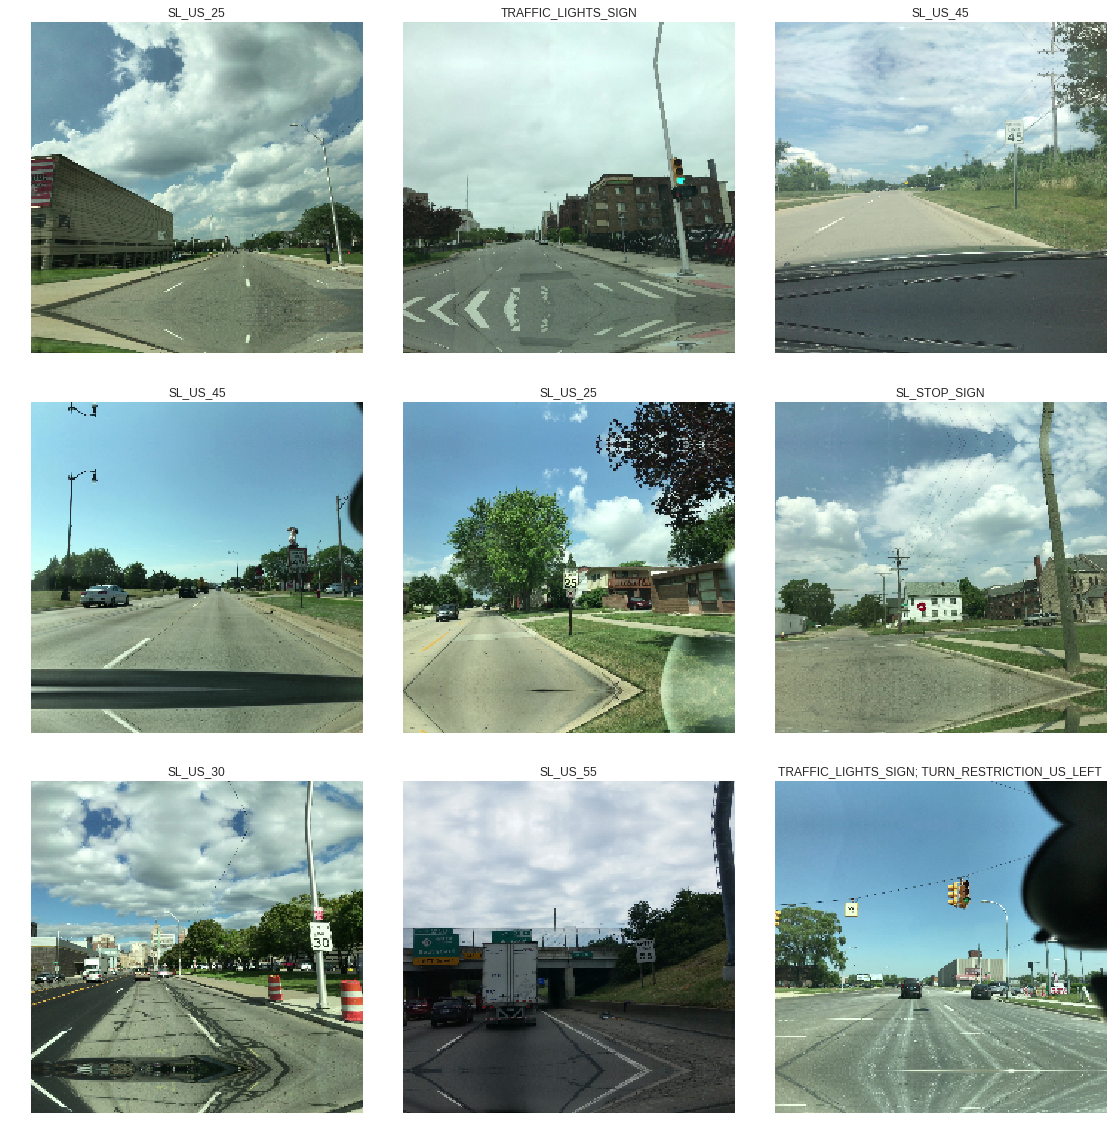

In [74]:
#show_image_batch(md.train_dl, classes=['NO_TRAFFIC_SIGN'], rows=1, figsize=(5,5))
x,y = next(iter(md.train_dl))
x,y = x.cpu(),y.cpu()
show_images(x, y, 3, md.train_ds.classes, figsize=(16,16))

In [67]:
type(md.train_ds.classes)

numpy.str_

In [40]:

from fastai.metrics import *
from fastai.layers import *
head_reg4 = nn.Sequential(Flatten(), nn.Linear(512 * 7*7,23), nn.Sigmoid())
learner = ConvLearner(md, f_model,pretrained=False,loss_fn=nn.BCELoss(), custom_head=head_reg4,metrics=accuracy)
print(learner)



ConvLearner(data=<fastai.data.DataBunch object at 0x7f76e8896b38>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps

In [0]:
learner.fit_one_cycle(3)

epoch  train loss  valid loss  accuracy


In [31]:
from fastai.train import *
lr = 1e-3
lr_find(learner)

epoch  train loss  valid loss
0      0.668557  
1      0.663524  


KeyboardInterrupt: ignored

# Large size Images

Size of the images are large ,as we are using resnet34 (224 * 224) hence resized data and  storing in a folder ahead ,to save processing time during training.

In [0]:
tfms = tfms_from_model(f_model, sz,aug_tfms=transforms_side_on, crop_type=CropType.NO)

def get_data(sz, batch_size):  
    

    data = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs=bs, 
                                        tfms=tfms,)
    return data if sz > 300 else data.resize(340, 'tmp')

In [81]:
temp()

> <ipython-input-80-09587e7d8432>(3)temp()
-> md = image_data_from_csv(PATH, JPEGS, csv_labels=MC_CSV)
(Pdb) s
--Call--
> /usr/local/lib/python3.6/dist-packages/fastai/vision/data.py(243)image_data_from_csv()
-> def image_data_from_csv(path:PathOrStr, folder:PathOrStr='.', sep=None, csv_labels:PathOrStr='labels.csv', valid_pct:float=0.2,
(Pdb) n
> /usr/local/lib/python3.6/dist-packages/fastai/vision/data.py(246)image_data_from_csv()
-> fnames, labels = csv_to_fns_labels(path/csv_labels, suffix=suffix, label_delim=sep)
(Pdb) s
--Call--
> /usr/lib/python3.6/pathlib.py(896)__truediv__()
-> def __truediv__(self, key):
(Pdb) n
> /usr/lib/python3.6/pathlib.py(897)__truediv__()
-> return self._make_child((key,))
(Pdb) n
--Return--
> /usr/lib/python3.6/pathlib.py(897)__truediv__()->PosixPath('/c...e/labels.csv')
-> return self._make_child((key,))
(Pdb) n
--Call--
> /usr/local/lib/python3.6/dist-packages/fastai/vision/data.py(232)csv_to_fns_labels()
-> def csv_to_fns_labels(csv_path:PathOrStr, 

BdbQuit: ignored


# Using class weights to tackle the unbalanced Data.

The classes are highly imbalanced ,hence used sklearn's compute_class_weight to calculate the weights according to
class distribution.
These class weights are passed to the CrossEntropyLoss.


In [0]:
df['cat'].unique()

array([ 40,  10,  21,  28, 123,  23,  39,  22,  24,  25,  29,  20,  43,  27,  41,  26,  31,  69,  18,  30,
        16,  19,  42,  17])

In [0]:
data = get_data(sz,bs)

As seen below ,the largest class Label (NO_TRAFFIC_SIGN) is given the lowest weight ,while SL_US_5 is given highest weight.

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',df['cat'].unique(),df['cat'])
  
class_weights = torch.FloatTensor(class_weights).cuda()
class_weights


   1.5036
   0.1582
   0.8513
   2.1212
   0.3130
   0.6793
   0.5745
   0.6941
   0.7973
   2.4088
   1.5166
   0.8896
   0.8868
   2.8314
   1.6944
   0.8276
   9.6833
   2.1235
  50.9649
   7.7158
 129.1111
  37.9739
  69.1667
  71.7284
[torch.cuda.FloatTensor of size 24 (GPU 0)]

# Class weights and precompute = False

1. As  the Classes are highly imbalanced ,using precision,recall along with accuracy to see the performance of the model.
2. Also found that precompute=True reduces performance ,so did not use any precomputed activations

In [0]:
learn  =  ConvLearner.pretrained(f_model, data, metrics=[accuracy,precision,recall],precompute=False)
learn.crit = torch.nn.CrossEntropyLoss(weight=class_weights)
learn.opt_fn = optim.Adam

In [0]:
lrf=learn.lr_find(1e-5,100)

 56%|█████▌    | 649/1162 [03:10<03:09,  2.70it/s, loss=7.61]

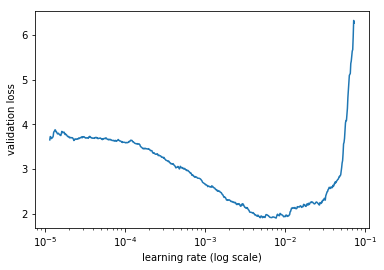

In [0]:
learn.sched.plot()

In [0]:
lr = 2e-3

# Class weights do not help ,Stratification might be useful.

But looks like ,class_weights do not give good results,hence dropping it.The other option I need to try is using StratifiedKFold .

In [0]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.387816   1.239709   0.135757   0.181391   0.222426  


[array([1.23971]),
 0.13575731497418245,
 0.18139138156986254,
 0.2224258885860596]

In [0]:
learn.crit = torch.nn.CrossEntropyLoss()


In [0]:
learn.set_data(get_data(299, bs)) 
learn.fit(lr, 2, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.932589   1.766415   0.442018   0.37616    0.073019  
    1      1.834503   1.703264   0.455465   0.452973   0.100754  
    2      1.76276    1.666432   0.465469   0.459408   0.10475   



[array([1.66643]),
 0.46546901893287435,
 0.4594084157870475,
 0.10474981013123506]

In [0]:
lrs = np.array([lr/1000,lr/100,lr])

In [0]:
learn.freeze_to(-2)

 74%|███████▍  | 432/581 [04:24<01:14,  1.99it/s, loss=6.8] 

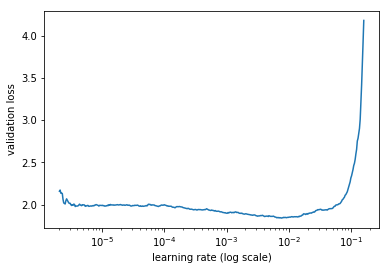

In [0]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [0]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.794009   1.656239   0.470525   0.494784   0.124795  


[array([1.65624]), 0.4705249569707401, 0.4947835247001529, 0.12479467742077796]

# Precision is improving but Recall is low.

Accuracy and precision are improving ,but Recall remains low. This could be due to missing annotations in many images.
But val_loss is still high.

In [0]:
learn.fit(lrs/5, 3, cycle_len=2,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.435256   1.394394   0.545288   0.635535   0.239797  
    1      1.381799   1.382652   0.550022   0.640931   0.247199  
    2      1.387256   1.338477   0.560241   0.655918   0.264281  
    3      1.336033   1.302555   0.574225   0.666092   0.28664   
    4      1.252182   1.28896    0.576592   0.672842   0.295826  
    5      1.246087   1.28702    0.577775   0.675946   0.294296  
    6      1.258513   1.262567   0.587672   0.674761   0.31415   
    7      1.216929   1.238405   0.592083   0.683653   0.335879  
    8      1.146787   1.216251   0.598107   0.6783     0.355186  
    9      1.135972   1.201737   0.600904   0.680881   0.361598  
    10     1.084736   1.192358   0.60725    0.686992   0.369417  
    11     1.046773   1.188046   0.607466   0.689089   0.373786  
    12     1.043113   1.186086   0.609617   0.687942   0.3773    
    13     1.03719    1.185892   0.608111   0.692713   0.374948  


[array([1.18589]), 0.6081110154905336, 0.6927126633819856, 0.37494762457365133]

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.060684   1.182132   0.609725   0.689509   0.389663  


[array([1.18213]), 0.6097246127366609, 0.689509051479718, 0.3896630914154372]

In [0]:
learn.save("preci_66")

In [0]:
learn.load("preci_66")

In [0]:
x,y=next(iter(data.val_dl))
probs = F.softmax(predict_batch(learn.model,x),-1)


x,preds =  to_np(x),to_np(probs)
                           
preds = np.argmax(preds,-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


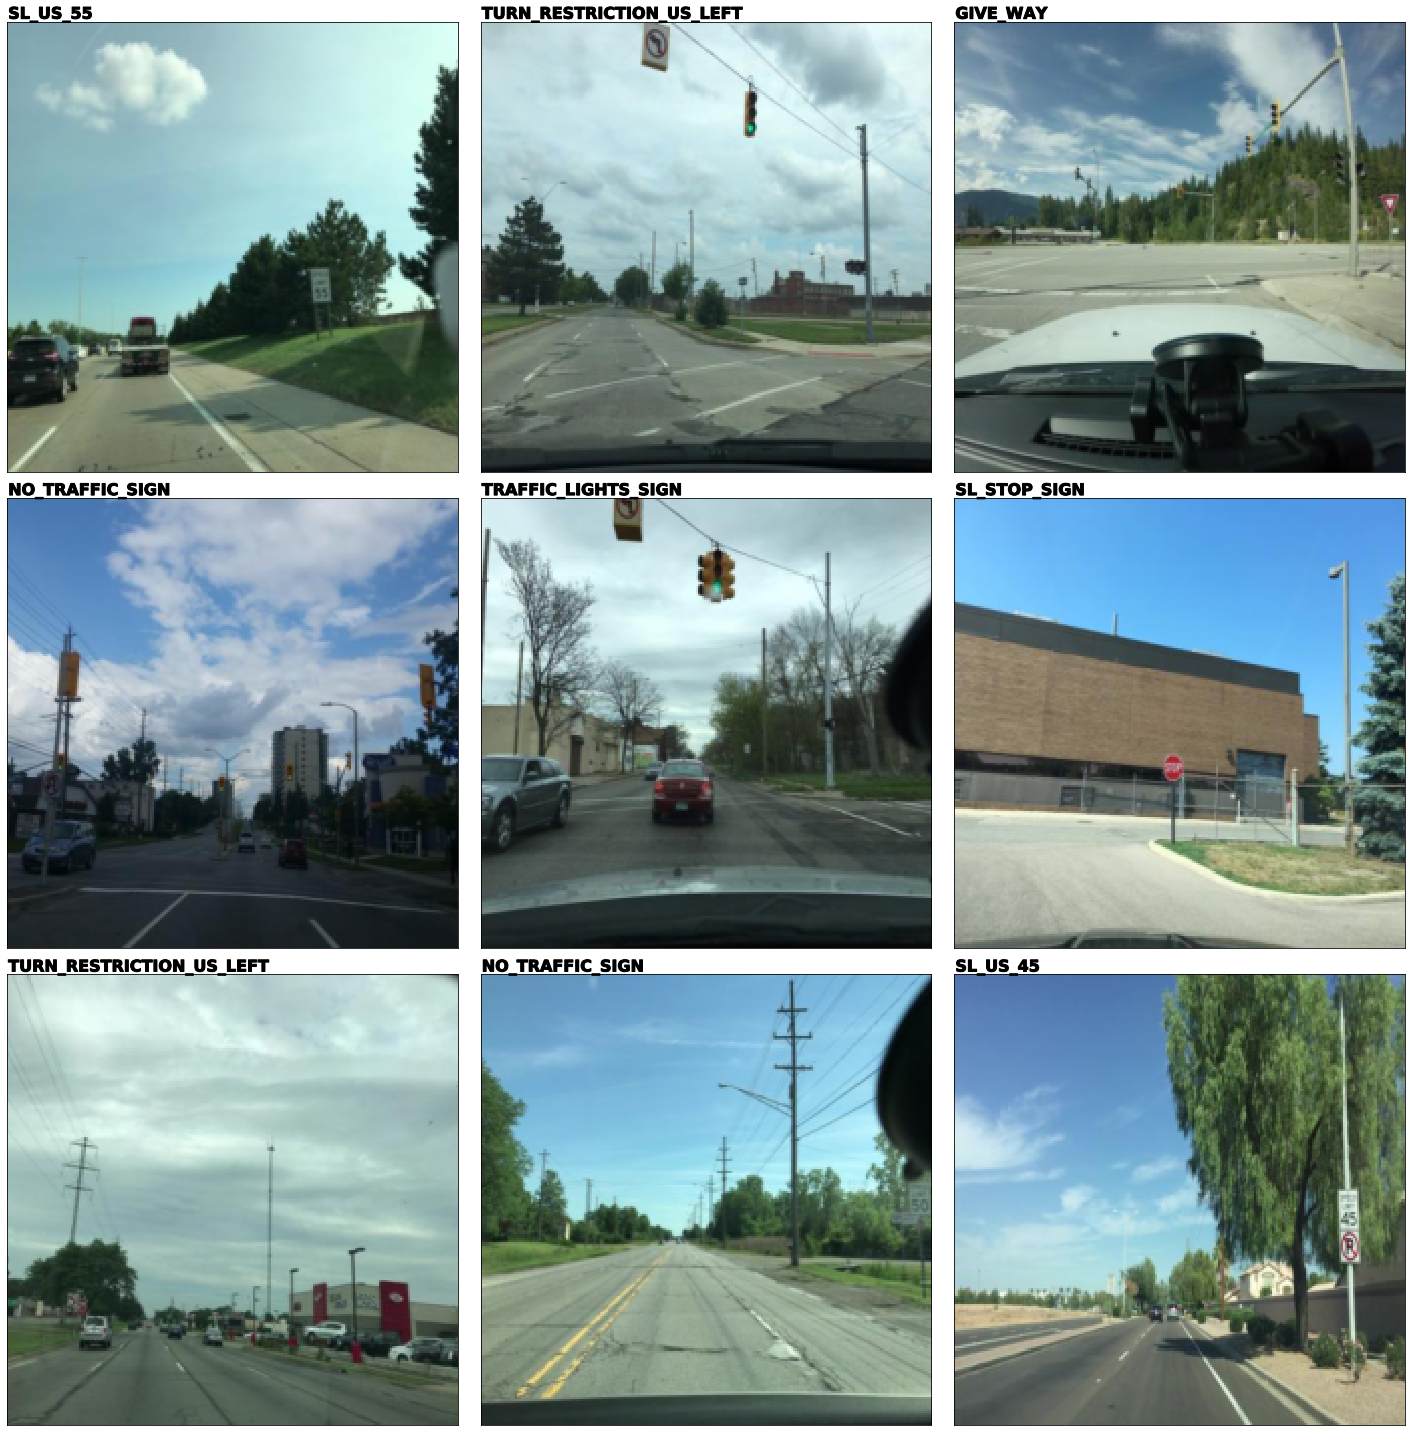

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=16,color ='white'):
    text = ax.text(*xy, txt,
        verticalalignment='bottom', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)  


fig,axes=  plt.subplots(3,3,figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.denorm(x)[i+15]
    b=data.classes[preds[i+15]]
    ax = show_img(ima,figsize=(12,12),ax=ax)
    draw_text(ax,(0,0),CLASS_NAME_DICT[int(b)],color='black')
plt.tight_layout()

# Training with 1Cycle.

This section is based on :https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb

In [0]:
data = get_data(sz,512)

# Get the best weight decay by comparing with few values.

In [0]:
learn_1cycle = ConvLearner.pretrained(f_model, data, precompute=False)
learn_1cycle.crit = F.nll_loss
learn_1cycle.opt_fn = optim.Adam
learn_1cycle.lr_find(wds=1e-1,start_lr=0.01,end_lr=100)

 38%|███▊      | 220/581 [01:45<02:53,  2.08it/s, loss=9.45]

In [0]:
trn_lossesw1 = learn_1cycle.sched.losses
val_lossesw1 = learn_1cycle.sched.val_losses
lrsw1 = learn_1cycle.sched.lrs

In [0]:
learn_1cycle = ConvLearner.pretrained(f_model, data, precompute=False)
learn_1cycle.crit = F.nll_loss
learn_1cycle.opt_fn = optim.Adam
learn_1cycle.lr_find(wds=1e-2,start_lr=0.01,end_lr=100)


 36%|███▋      | 212/581 [01:43<02:55,  2.10it/s, loss=9.29]

In [0]:
trn_lossesw2 = learn_1cycle.sched.losses
val_lossesw2 = learn_1cycle.sched.val_losses
lrsw2 = learn_1cycle.sched.lrs

In [0]:
learn_1cycle = ConvLearner.pretrained(f_model, data, precompute=False)
learn_1cycle.crit = F.nll_loss
learn_1cycle.opt_fn = optim.Adam
learn_1cycle.lr_find(wds=1e-3,start_lr=0.01,end_lr=100)

 35%|███▍      | 202/581 [01:36<03:01,  2.09it/s, loss=9.34]

In [0]:
trn_lossesw3 = learn_1cycle.sched.losses
val_lossesw3 = learn_1cycle.sched.val_losses
lrsw3 = learn_1cycle.sched.lrs

In [0]:
learn_1cycle = ConvLearner.pretrained(f_model, data, precompute=False)
learn_1cycle.crit = F.nll_loss
learn_1cycle.opt_fn = optim.Adam
learn_1cycle.lr_find(wds=1e-4,start_lr=0.01,end_lr=100)

 35%|███▌      | 204/581 [01:36<02:57,  2.13it/s, loss=9.43]

In [0]:
trn_lossesw4 = learn_1cycle.sched.losses
val_lossesw4 = learn_1cycle.sched.val_losses
lrsw4 = learn_1cycle.sched.lrs

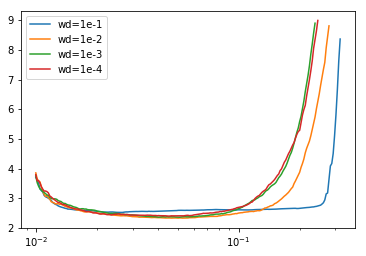

In [0]:
fig, ax = plt.subplots(1,1)
ax.plot(lrsw1[:-1],trn_lossesw1[:-1], label='wd=1e-1')
ax.plot(lrsw2[:-1],trn_lossesw2[:-1], label='wd=1e-2')
ax.plot(lrsw3[:-1],trn_lossesw3[:-1], label='wd=1e-3')
ax.plot(lrsw4[:-1],trn_lossesw4[:-1], label='wd=1e-4')
ax.set_xscale('log')
ax.legend(loc='upper left')

In [0]:
learn_1cycle  =  ConvLearner.pretrained(f_model, data,metrics=[accuracy,precision,recall], precompute=False)
learn_1cycle.crit  = F.nll_loss
learn_1cycle.opt_fn = optim.Adam

From the Graph , 1e-1 seems to run longest without losses going high . But it turns that with 1e-1 results are pretty bad. So using 1e-4 ,this needs to be investigated more.

In [0]:
learn_1cycle.lr_find(wds=1e-4,end_lr=100)

 67%|██████▋   | 391/581 [02:22<00:55,  3.40it/s, loss=9.82]

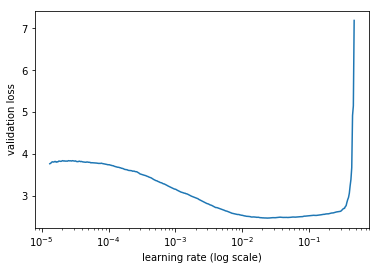

In [0]:
learn_1cycle.sched.plot(10,1)

In [0]:
lr = 5e-3

In [0]:
learn_1cycle.fit(lr,1,cycle_len=20,use_clr_beta=(10,20,0.95,0.85),wds=1e-4)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.995683   1.770484   0.438468   0.411697   0.091086  
    1      1.892659   1.719294   0.44901    0.441768   0.10674   
    2      1.844022   1.701557   0.44858    0.473948   0.109834  
    3      1.825081   1.684322   0.455357   0.482764   0.117124  
    4      1.802958   1.67139    0.468266   0.469057   0.11003   
    5      1.800384   1.68793    0.446751   0.458629   0.090259  
    6      1.798132   1.67963    0.460736   0.488624   0.131151  
    7      1.822205   1.689045   0.460413   0.46094    0.109651  
    8      1.794968   1.669528   0.454066   0.474353   0.125092  
    9      1.796761   1.682146   0.461166   0.443779   0.096054  
    10     1.753164   1.646696   0.469664   0.476667   0.112914  
    11     1.747649   1.635068   0.463425   0.515672   0.126542  
    12     1.730536   1.627593   0.473752   0.520822   0.13745   
    13     1.69614    1.597214   0.486553   0.527075   0.14175   
    14   

[array([1.5447]), 0.5019363166953529, 0.5686519197264491, 0.17267549742392194]

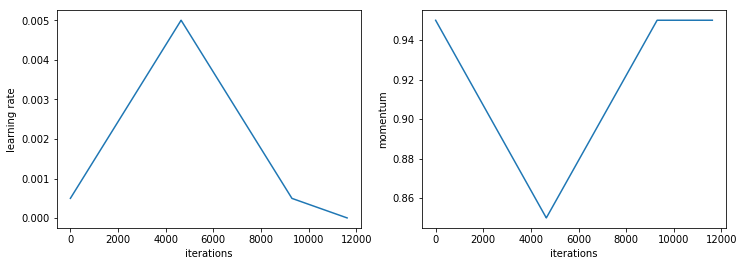

In [0]:
learn_1cycle.sched.plot_lr()

In [0]:
learn_1cycle.save("before_unfreeze_1cycle")

In [0]:
learn_1cycle.load("before_unfreeze_1cycle")

In [0]:
learn_1cycle.unfreeze()

In [0]:
learn_1cycle.fit(lrs=[lr/100, lr/10, lr],n_cycle = 1, wds=1e-4, use_clr_beta=(10,10,0.95,0.85),
          cycle_len=40)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.306912   1.203535   0.601011   0.685359   0.321018  
    1      1.142794   1.08679    0.63651    0.716988   0.400401  
    2      0.988167   1.044168   0.659639   0.740746   0.4374    
    3      0.947385   1.00982    0.673193   0.723341   0.492672  
    4      0.881618   0.996637   0.677711   0.722014   0.530891  
    5      0.847063   0.977767   0.690404   0.750528   0.516083  
    6      0.806285   0.951826   0.697827   0.758087   0.532349  
    7      0.751054   0.966578   0.696859   0.720926   0.569827  
    8      0.707421   0.988202   0.691588   0.710404   0.570476  
    9      0.681825   0.955462   0.706756   0.721903   0.586669  
    10     0.65378    0.97944    0.707293   0.751441   0.56834   
    11     0.658462   0.93382    0.718158   0.745212   0.587669  
    12     0.606808   0.971665   0.725581   0.750705   0.591934  
    13     0.589256   0.965812   0.711381   0.709768   0.641541  
    14   

[array([1.12888]), 0.8023881239242685, 0.8178979720027205, 0.7549477207693636]

In [0]:
learn_1cycle.save("unfreeze_1cycle")

In [0]:
learn_1cycle.load("unfreeze_1cycle")

In [0]:
x,y=next(iter(data.val_dl))
probs = F.softmax(predict_batch(learn_1cycle.model,x),-1)


x,preds =  to_np(x),to_np(probs)
                           
preds = np.argmax(preds,-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


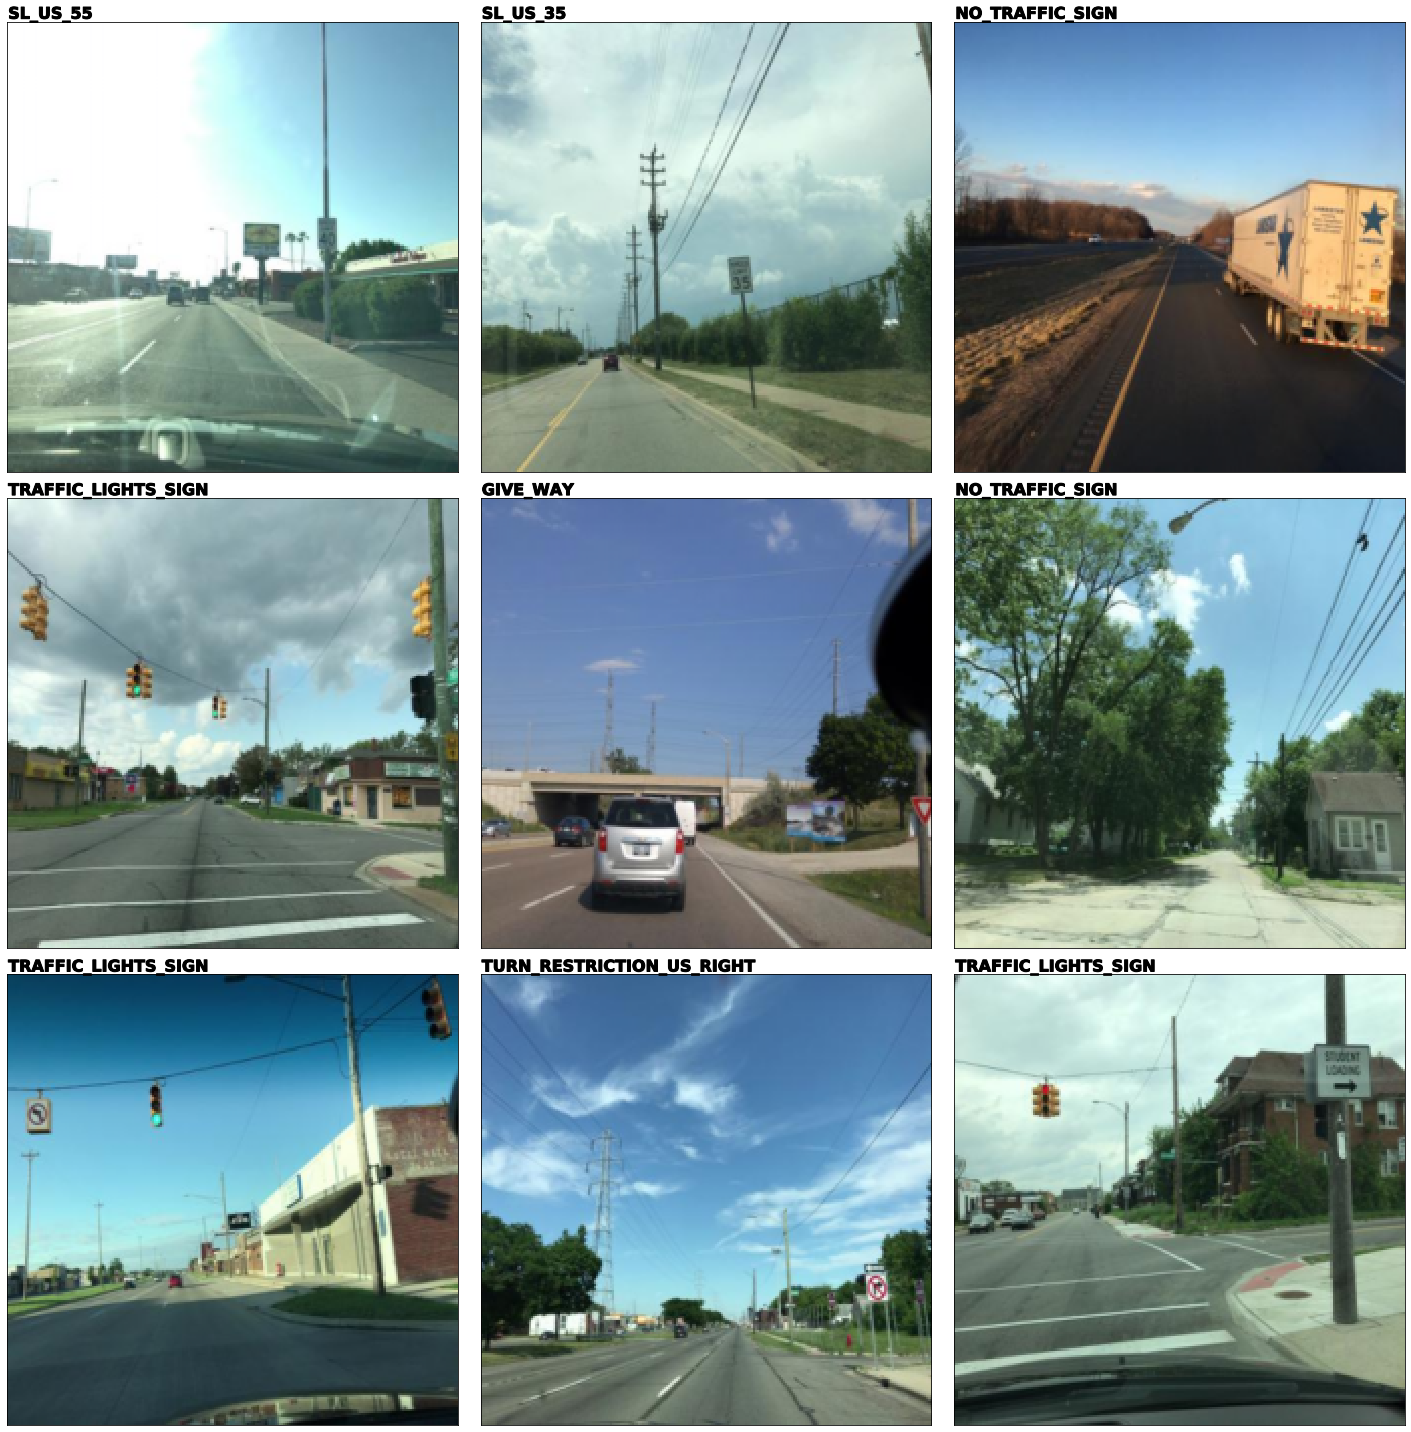

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=16,color ='white'):
    text = ax.text(*xy, txt,
        verticalalignment='bottom', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)  


fig,axes=  plt.subplots(3,3,figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.denorm(x)[i+35]
    b=data.classes[preds[i+35]]
    ax = show_img(ima,figsize=(12,12),ax=ax)
    draw_text(ax,(0,0),CLASS_NAME_DICT[int(b)],color='black')
plt.tight_layout()